# TP Aprendizaje Automático 2
- Alsop Agustin
- Hachen Rocio

## Introducción

### Librerias

In [505]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report
from matplotlib.lines import Line2D
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

### Funciones

### Carga de datos

In [506]:
data = pd.read_csv('weatherAUS.csv')

In [507]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [508]:
ciudades = list(data['Location'].unique())
len(ciudades)

49

In [509]:
# import random
# ciudades = list(data['Location'].unique())
# ciudades_elegidas = []
# for i in range(0,10):
#     aleatorio = random.randint(0,48-i)
#     ciudades_elegidas.append(ciudades[aleatorio])
#     ciudades.pop(aleatorio)
ciudades_elegidas = ['Cobar',
 'Perth',
 'Penrith',
 'WaggaWagga',
 'Hobart',
 'Cairns',
 'Bendigo',
 'Uluru',
 'MountGinini',
 'MountGambier']

In [510]:
df = data[data['Location'].isin(ciudades_elegidas)]
df['Location'].unique()

array(['Cobar', 'Penrith', 'WaggaWagga', 'MountGinini', 'Bendigo',
       'Cairns', 'MountGambier', 'Perth', 'Hobart', 'Uluru'], dtype=object)

In [511]:
print(df.columns)
print(df.dtypes)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


## Ejercicio 1

### Codificación de Variables

In [512]:
df_use = df.copy() # Para evitar warnings
df['RainToday'] = df_use['RainToday'].astype('category')
df['RainTomorrow'] = df_use['RainTomorrow'].astype('category')
df['WindGustDir'] = df_use['WindGustDir'].astype('category')
df['WindDir9am'] = df_use['WindDir9am'].astype('category')
df['WindDir3pm'] = df_use['WindDir3pm'].astype('category')
df['Date'] = df_use['Date'].astype('datetime64[ns]')
df

C:\Users\rocio\AppData\Local\Temp\ipykernel_34260\3150204730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainToday'] = df_use['RainToday'].astype('category')
C:\Users\rocio\AppData\Local\Temp\ipykernel_34260\3150204730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainTomorrow'] = df_use['RainTomorrow'].astype('category')
C:\Users\rocio\AppData\Local\Temp\ipykernel_34260\3150204730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,...,NaN,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


### Análisis y decisión sobre datos faltantes




In [513]:
# Nulls por Variable
nulls = df.isna().sum()
print(nulls)

print(f' Valores null totales: {nulls.sum()}')

Date                 0
Location             0
MinTemp            165
MaxTemp            100
Rainfall           390
Evaporation      10781
Sunshine         14528
WindGustDir        649
WindGustSpeed      646
WindDir9am        1567
WindDir3pm         461
WindSpeed9am       331
WindSpeed3pm       299
Humidity9am        714
Humidity3pm        542
Pressure9am       6139
Pressure3pm       6126
Cloud9am         10362
Cloud3pm         10005
Temp9am            488
Temp3pm            336
RainToday          390
RainTomorrow       392
dtype: int64
 Valores null totales: 65411


### Tratamiento de los valores nulos
1) Las filas que tengan Nulls en la columna de la variable a predecir se descartán

2) Las filas que tengan al menos un 50% de Nulls se borrarán, ya que consideramos que rellenarlo por imputación resultaría en un dato creado artificialmente. Verificamos que al hacer esto no se borrara una gran cantidad de información.

3) Para el resto de los datos Null, y luego de haber hecho la validación cruzada, se realizarán imputaciones dependiendo de su distribución y tipo de variable.
    - Asimetría -> Mediana
    - Normal -> Media
    - Bimodal y Categorica -> KNN

#### Paso 1

In [514]:
# Eliminación de las row donde la variable de salida sea null
df = df.dropna(subset=['RainTomorrow'])
print(df['RainTomorrow'].isna().sum())

0


In [515]:
# Guardamos la cantidad total de filas para luego compararlas
con_null = df.shape[0]

#### Paso 2

In [516]:
# Nos quedamos solo con aquellas rows con al menos 11 variables no Null
df = df.dropna(thresh=11)
df.isna().sum()

Date                 0
Location             0
MinTemp             21
MaxTemp              5
Rainfall           174
Evaporation      10348
Sunshine         14046
WindGustDir        370
WindGustSpeed      367
WindDir9am        1377
WindDir3pm         315
WindSpeed9am       154
WindSpeed3pm       158
Humidity9am        519
Humidity3pm        385
Pressure9am       5820
Pressure3pm       5815
Cloud9am          9954
Cloud3pm          9600
Temp9am            308
Temp3pm            192
RainToday          174
RainTomorrow         0
dtype: int64

In [517]:
sin_null = df.shape[0] # Cantidad de filas restantes luego de la eliminación de Nulls
print(f'Cantidad de filas en el dataset previo al paso 2: {con_null}\nCantidad de filas en el dataset luego de quitar nulls: {sin_null}\nFilas perdidas: {con_null - sin_null}\nPorcentaje de filas perdidas: {round((con_null-sin_null)*100/con_null,2)}%')

Cantidad de filas en el dataset previo al paso 2: 28789
Cantidad de filas en el dataset luego de quitar nulls: 28691
Filas perdidas: 98
Porcentaje de filas perdidas: 0.34%


Debido a que el porcentajes de filas quitadas del data set representa un porcentaje minimo del total consideramos válida la operación

In [518]:
decision_map = {
    "No" : 0, "Yes" : 1
}

# Aplicamos el mapeo para crear una nueva columna
df['RainTomorrow'] = df['RainTomorrow'].map(decision_map)


### Validación Cruzada

In [519]:
# Division train - test
x = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

ratio_train = 0.8
ratio_test = 0.2

# Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y.values.reshape(-1,1), test_size=ratio_test, random_state=42) # se utiliza 42 para garantizar que cada vez que se corra el código se obtengan los mismos resultados

print(f'Cantidad de datos luego de la separación')
print(f'Train: {x_train.shape[0]} - 80%\n Test: {x_test.shape[0]} - 20%')

Cantidad de datos luego de la separación
Train: 22952 - 80%
 Test: 5739 - 20%


### Análisis descriptivo

In [520]:
print(x_train.describe(include='all'))

                                 Date Location       MinTemp       MaxTemp  \
count                           22952    22952  22936.000000  22948.000000   
unique                            NaN       10           NaN           NaN   
top                               NaN   Hobart           NaN           NaN   
freq                              NaN     2562           NaN           NaN   
mean    2013-04-19 10:23:11.565005056      NaN     11.286802     22.613827   
min               2008-07-01 00:00:00      NaN     -8.500000     -4.800000   
25%               2011-02-08 00:00:00      NaN      6.200000     16.600000   
50%               2013-06-28 12:00:00      NaN     10.700000     22.200000   
75%               2015-06-21 00:00:00      NaN     16.500000     28.900000   
max               2017-06-25 00:00:00      NaN     31.000000     46.600000   
std                               NaN      NaN      6.931129      8.242572   

            Rainfall   Evaporation      Sunshine WindGustDir  W

#### Matriz de Correlación

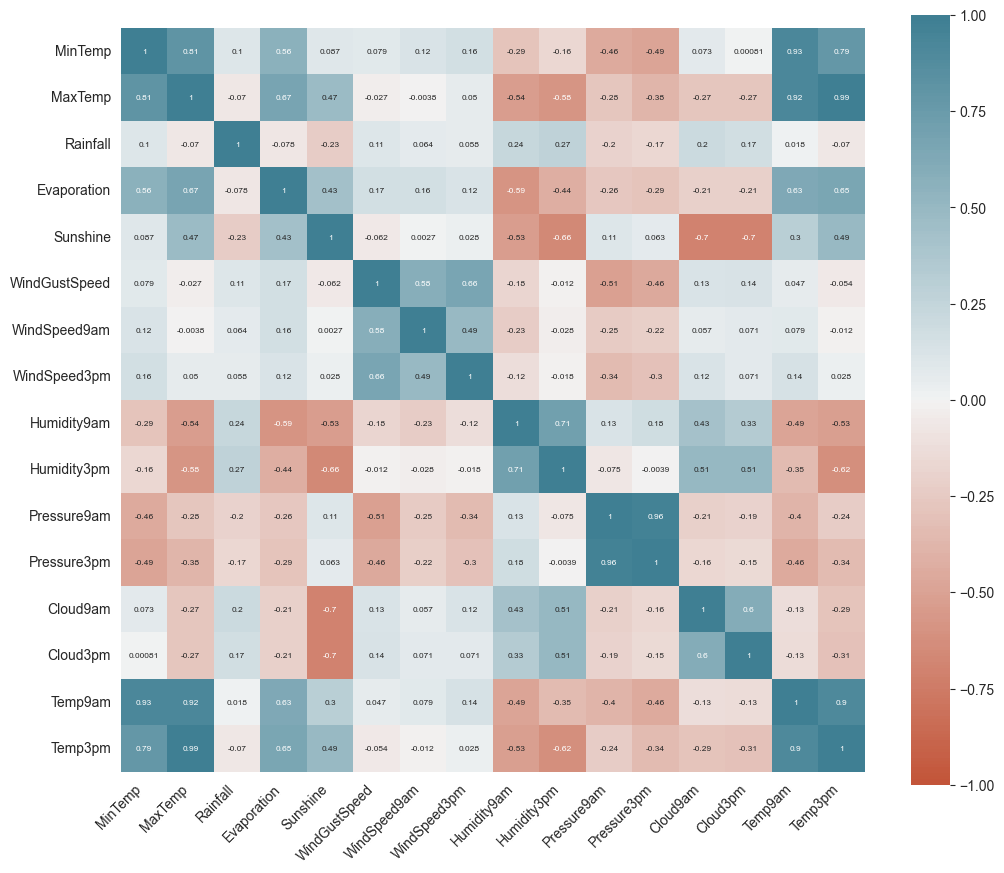

In [521]:
x_train_corr=pd.DataFrame(x_train,columns=x_train.drop(columns=['RainToday', 'Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']).columns)

plt.figure(figsize=(12,10))
corr = x_train_corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

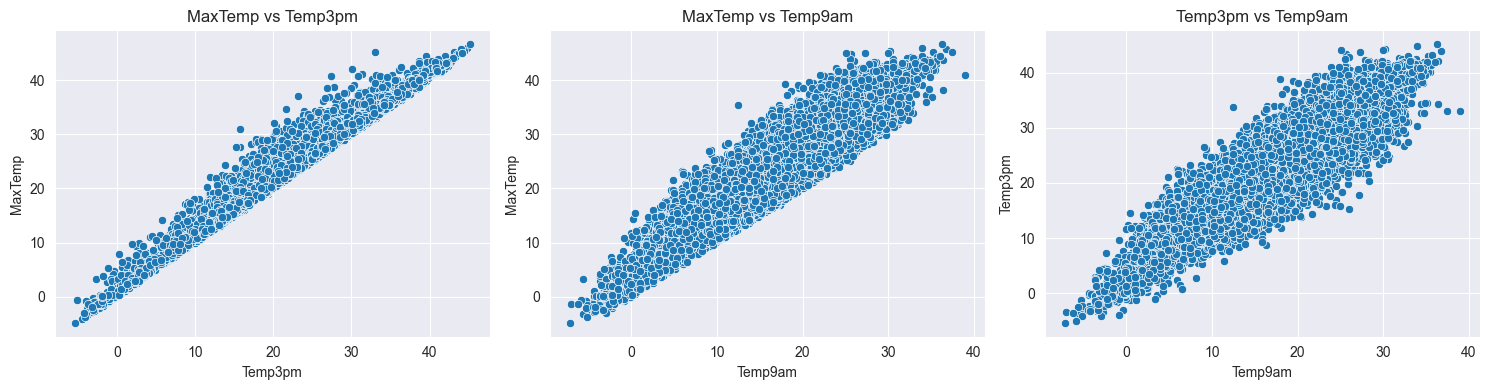

In [522]:
# Visualización de la relación entre algunas variables

pares = [('MaxTemp', 'Temp3pm'), ('MaxTemp', 'Temp9am'), ('Temp3pm', 'Temp9am')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

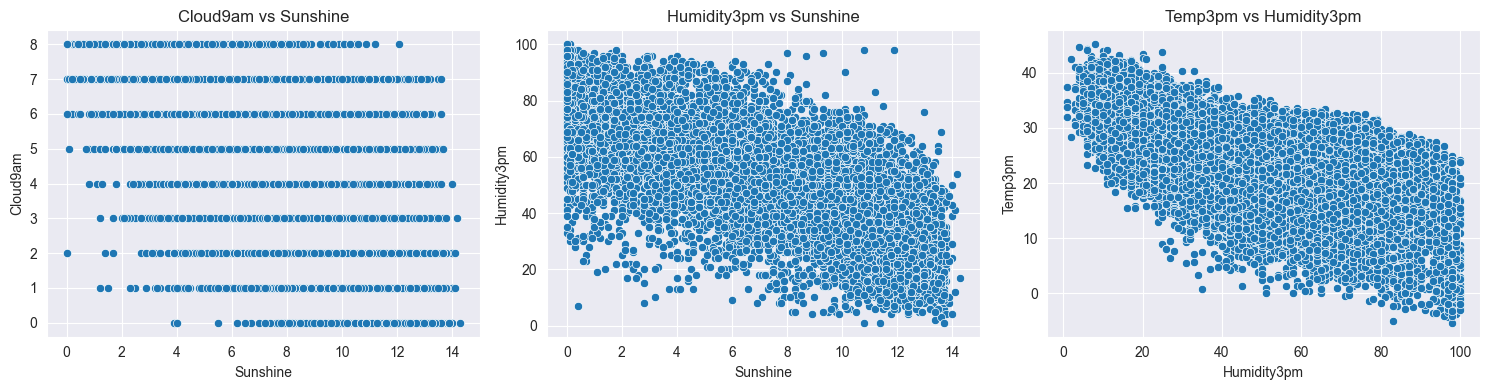

In [523]:
# Visualización de la relación entre algunas variables

pares = [('Cloud9am', 'Sunshine'), ('Humidity3pm', 'Sunshine'), ('Temp3pm', 'Humidity3pm')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

#### Analisis por variable individual

Para poder hacer un mejor análisis sobre los datos (presencia de outliers, distribución de los datos, etc.) decidimos graficar la distribución de cada variable. Además, incluímos la variable categórica en cada uno de los gráficos para poder apreciar mejor si los outliers realmente eran valores atípicos, o si se justificaban por su categoría.

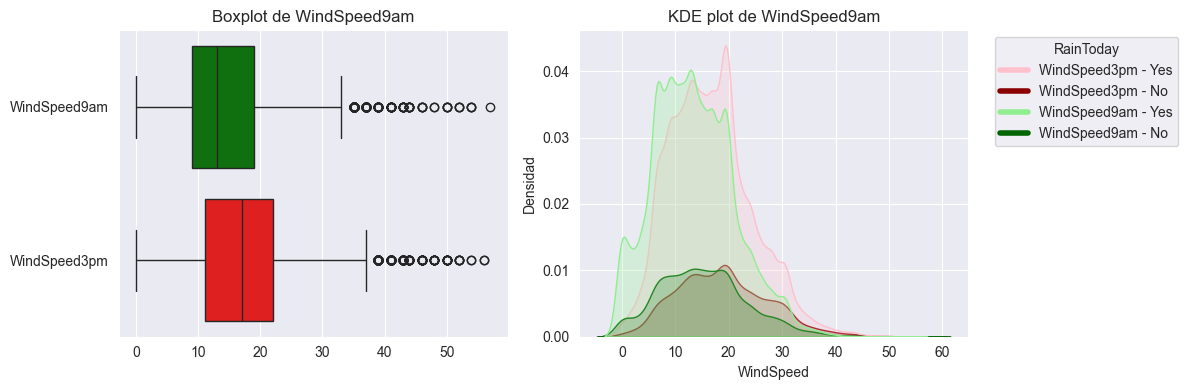

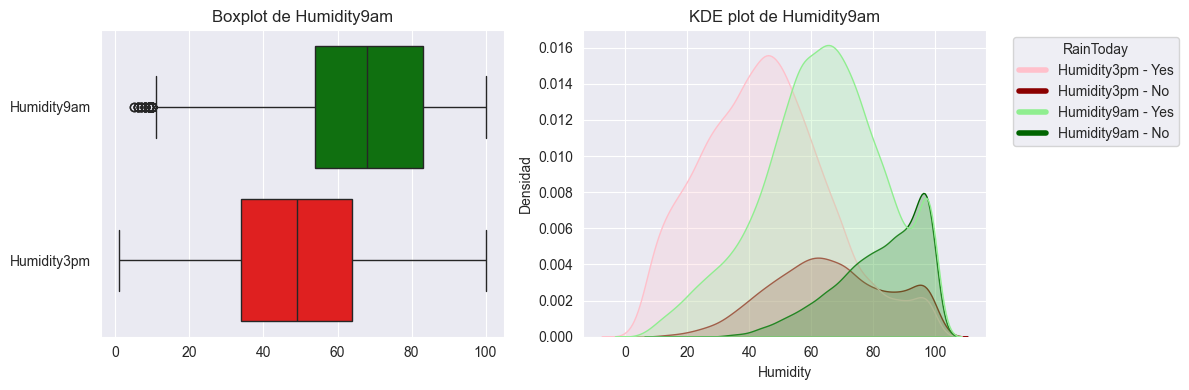

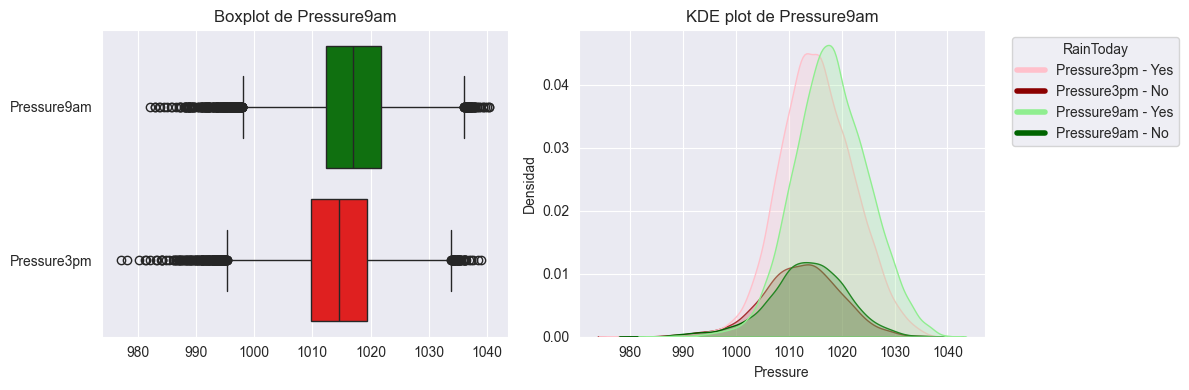

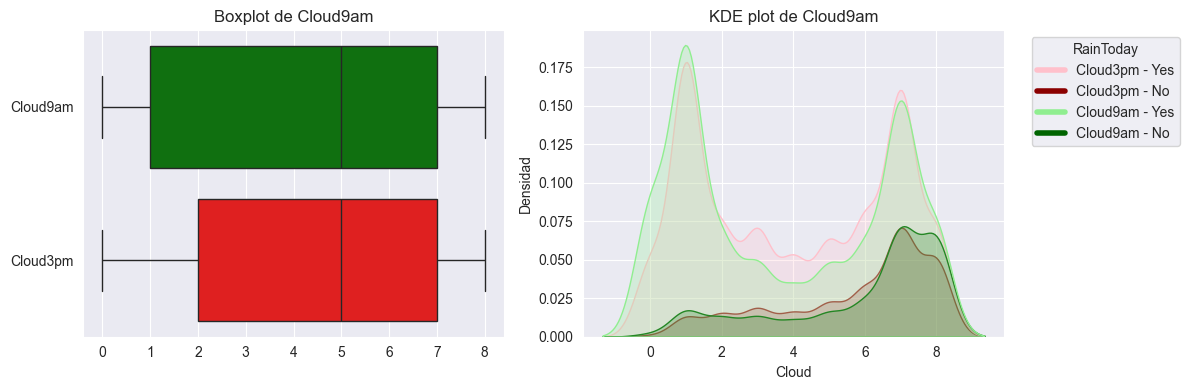

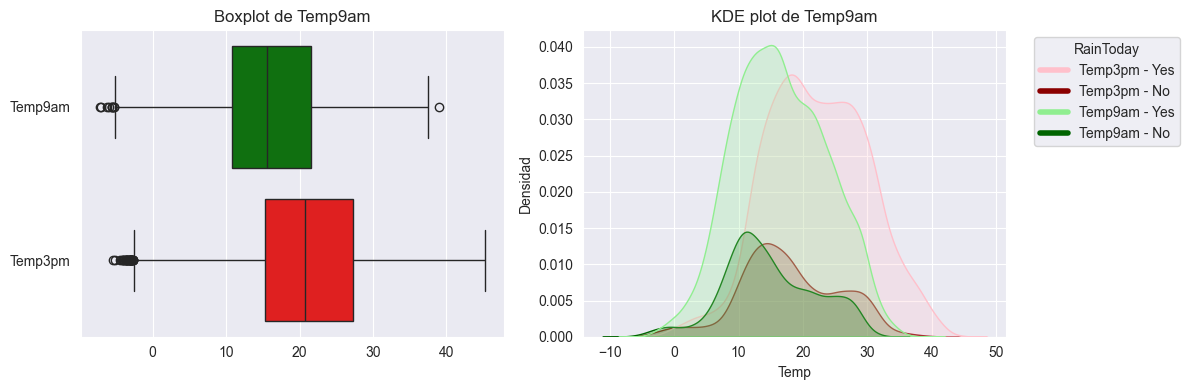

In [524]:


x_train_grafico=pd.DataFrame(x_train,columns=x_train.drop(columns=['Date', 'Location']).columns)

am_pm_list = ["WindSpeed","Humidity","Pressure","Cloud","Temp"]

sns.set_style("darkgrid")
# Definir las paletas personalizadas
palette_a = ['lightgreen', 'darkgreen']  # Verde oscuro y verde claro
palette_b = ['pink', 'darkred'] 
palette_c = ['green', 'red']           # Rojo claro y rojo oscuro
for variable in am_pm_list:

    am = variable + '9am'
    pm = variable + '3pm'
    # Crear la figura
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(data=x_train[[am,pm]], ax=axs[0], 
                palette=palette_c,orient="h")
    axs[0].set_title(f'Boxplot de {am}')

    # Graficar el KDE para Temp3pm con rojo oscuro y rojo claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=pm, fill=True, hue='RainToday', 
                palette=palette_b, label=pm)
    axs[1].set_title(f'KDE plot de {pm}')
    axs[1].set_ylabel('Densidad')


    # Graficar el KDE para Temp9am con verde oscuro y verde claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=am, fill=True, hue='RainToday', 
                palette=palette_a, label=am)
    axs[1].set_title(f'KDE plot de {am}')
    axs[1].set_ylabel('Densidad')

    # Añadir la leyenda personalizada que relacione los colores con 'Yes' y 'No'
    # Cada hue tiene 'Yes' y 'No', por lo que mostramos dos entradas para cada variable
    legend_labels = [f'{pm} - Yes', f'{pm} - No', f'{am} - Yes', f'{am} - No']
    colors = palette_b + palette_a  # Los colores que usaste

    # Crear los elementos de la leyenda

    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, legend_labels)]

    # Colocar la leyenda en la figura
    plt.legend(handles=legend_elements, title='RainToday', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(variable)
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    x_train_grafico = x_train_grafico.drop(columns=[am,pm])





MinTemp
count    22936.000000
mean        11.286802
std          6.931129
min         -8.500000
25%          6.200000
50%         10.700000
75%         16.500000
max         31.000000
Name: MinTemp, dtype: float64 



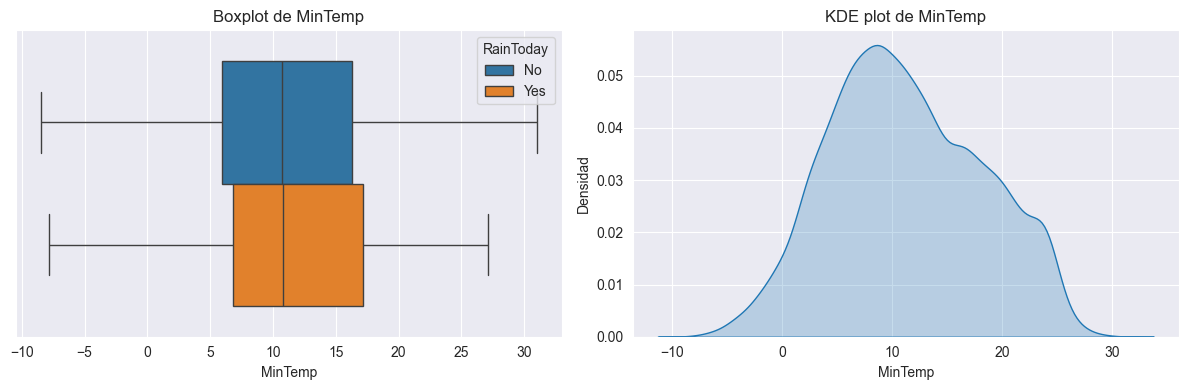

#############################################################################################
MaxTemp
count    22948.000000
mean        22.613827
std          8.242572
min         -4.800000
25%         16.600000
50%         22.200000
75%         28.900000
max         46.600000
Name: MaxTemp, dtype: float64 



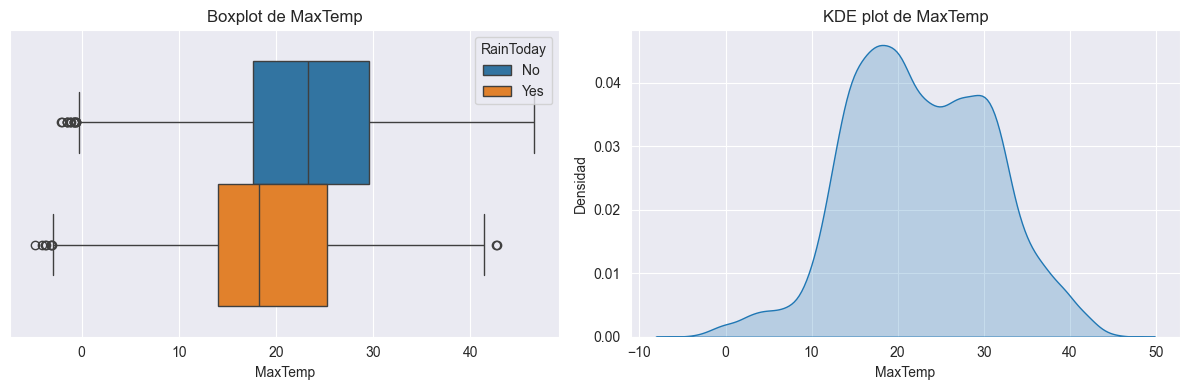

#############################################################################################
Rainfall
count    22822.000000
mean         2.283919
std          8.317022
min          0.000000
25%          0.000000
50%          0.000000
75%          0.600000
max        268.600000
Name: Rainfall, dtype: float64 



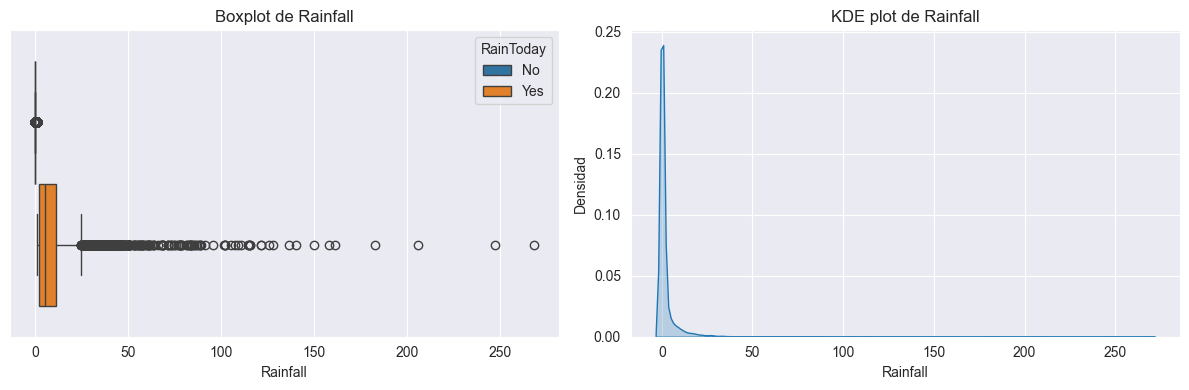

#############################################################################################
Evaporation
count    14703.000000
mean         5.021887
std          3.818004
min          0.000000
25%          2.200000
50%          4.200000
75%          7.000000
max         86.200000
Name: Evaporation, dtype: float64 



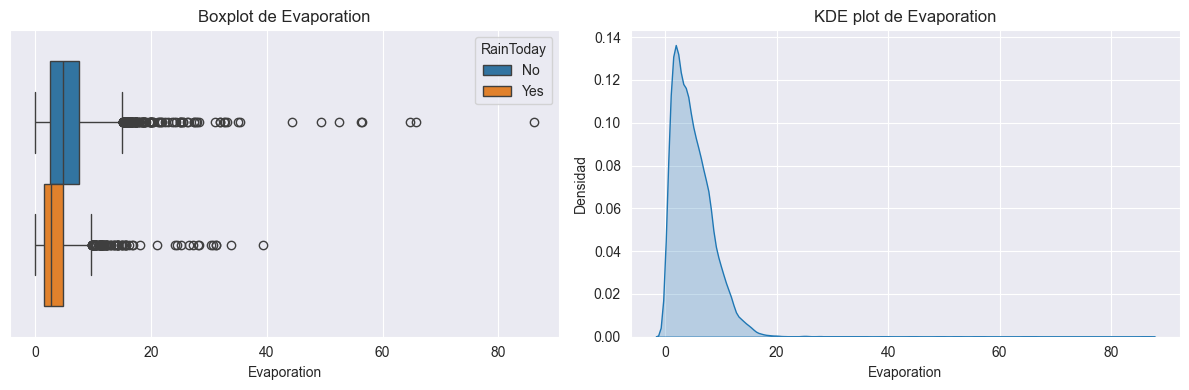

#############################################################################################
Sunshine
count    11719.000000
mean         7.560261
std          3.777268
min          0.000000
25%          4.800000
50%          8.200000
75%         10.600000
max         14.300000
Name: Sunshine, dtype: float64 



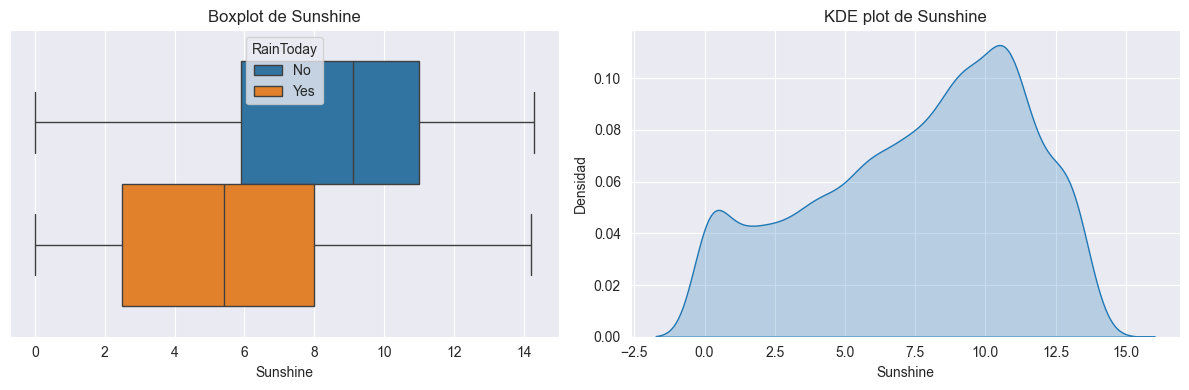

#############################################################################################
WindGustSpeed
count    22651.000000
mean        39.302062
std         13.813592
min          7.000000
25%         30.000000
50%         37.000000
75%         46.000000
max        115.000000
Name: WindGustSpeed, dtype: float64 



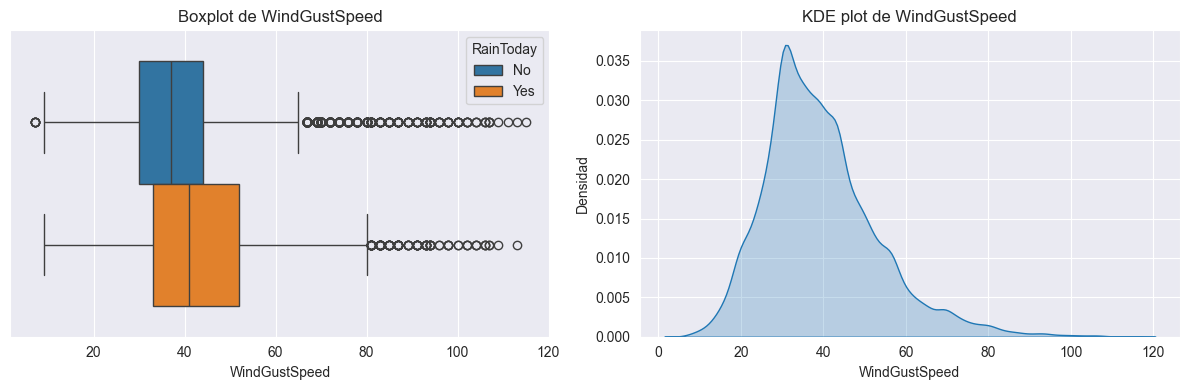

#############################################################################################
RainToday
count     22822
unique        2
top          No
freq      17814
Name: RainToday, dtype: object 



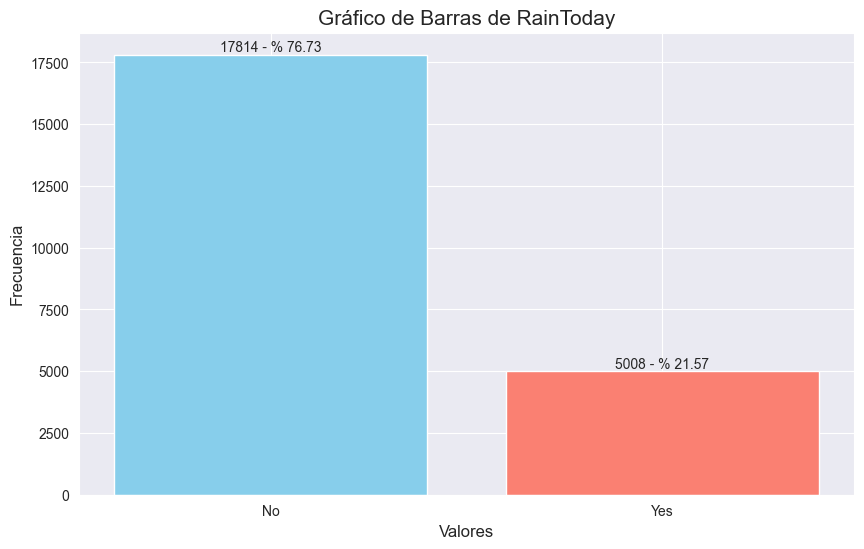

#############################################################################################
WindGustDir
count     22649
unique       16
top          SW
freq       2073
Name: WindGustDir, dtype: object 



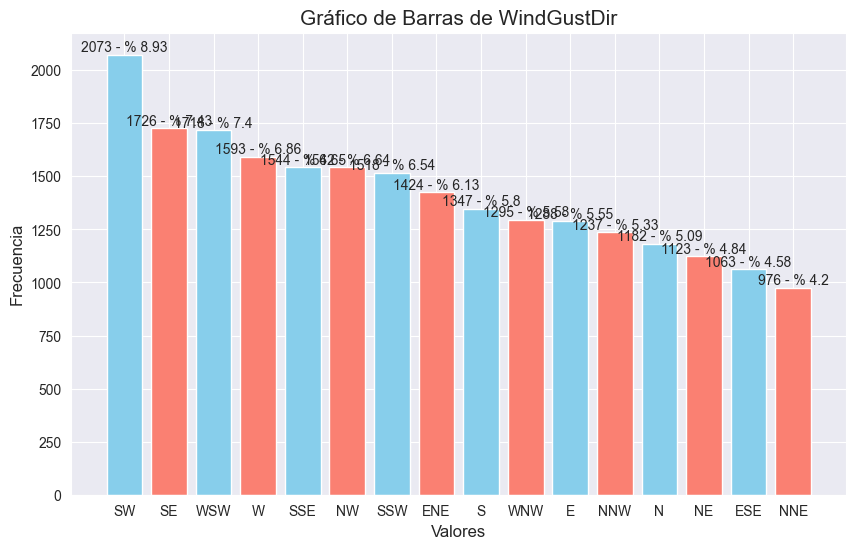

#############################################################################################
WindDir9am
count     21852
unique       16
top         SSE
freq       2290
Name: WindDir9am, dtype: object 



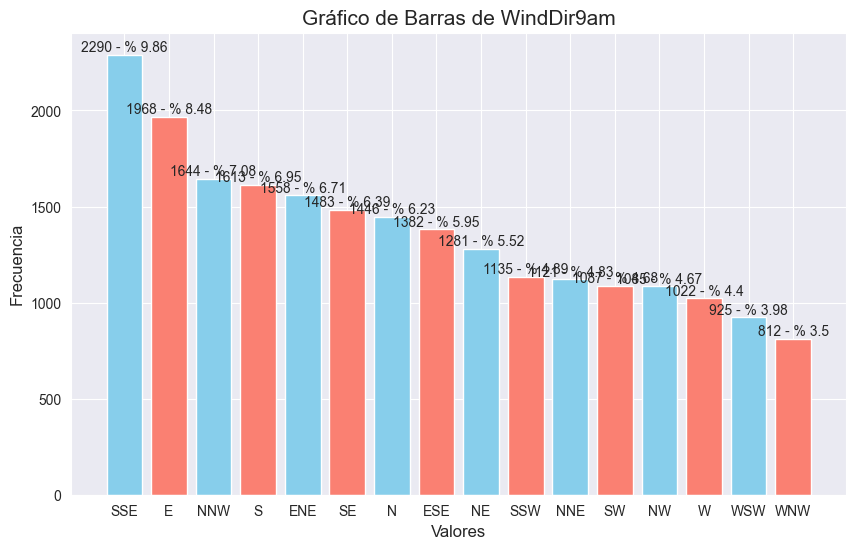

#############################################################################################
WindDir3pm
count     22698
unique       16
top          SW
freq       1908
Name: WindDir3pm, dtype: object 



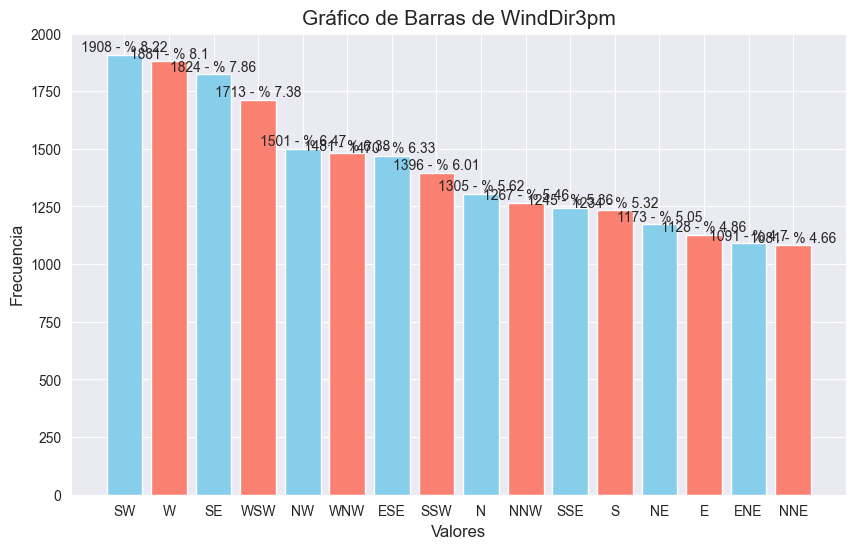

#############################################################################################


In [525]:
for columna in x_train_grafico:
    if not columna in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
        print(columna)
        print(x_train[columna].describe(), '\n')

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(data=x_train, x=columna, hue=f'RainToday', ax=axs[0])
        axs[0].set_title(f'Boxplot de {columna}')

        sns.kdeplot(data=x_train, x=columna, fill=True, ax=axs[1])
        axs[1].set_title(f'KDE plot de {columna}')
        axs[1].set_ylabel('Densidad')

        plt.tight_layout()
        plt.show()

        # for i in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        #     print(i)
        #     fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        #     sns.boxplot(data=x_train, x=columna, hue=f'{i}', ax=axs[0])
        #     axs[0].set_title(f'Boxplot de {columna}')

        #     '''sns.kdeplot(data=x_train, x=columna, fill=True, hue=f'{i}', ax=axs[1])
        #     axs[1].set_title(f'KDE plot de {columna}')
        #     axs[1].set_ylabel('Densidad')'''

        #     plt.tight_layout()
        #     plt.show()
        print('#############################################################################################')

for i in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    print(i)
    print(x_train[f'{i}'].describe(), '\n')

    count = x_train[f'{i}'].value_counts().reset_index()
    count.columns = ['Valores', 'Frecuencia']

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(count['Valores'].astype(str), count['Frecuencia'], color=['skyblue', 'salmon'])

    # Agregar título y etiquetas
    plt.title(f'Gráfico de Barras de {i}', fontsize=15)
    plt.xlabel('Valores', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Agregar el número encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text((bar.get_x() + bar.get_width() / 2.0), height, f'{int(height)} - % {round((int(height)/23215)*100,2)}', ha='center', va='bottom')

    # Mostrar el gráfico
    plt.show()
    print('#############################################################################################')



#### Paso 3 (Imputación de datos)

En base al análisis descriptivo, decidimos utilizar distintos métodos de imputación según la distribución y el tipo de variable.

### Continuas
- MinTemp: Media
- Temp9am: Media
- Rainfall: Mediana
- Evaporation: Mediana
- WindGustSpeed: Mediana
- Pressure3pm: Mediana
- Pressure9am: Mediana
- WindSpeed3pm: KNN
- WindSpeed9am: KNN
- Humidity3pm: KNN
- Humidity9am: KNN
- Cloud9am: KNN
- Cloud3pm: KNN
- Temp3pm: KNN
- MaxTemp: KNN
- Sunshine: KNN

### Cualitativas
- WindGustDir: KNN
- WindDir9am: KNN
- WindDir3pm: KNN
- RainToday: KNN

In [526]:
def simpleImputerPerMonth(x_train: pd.DataFrame, x_test: pd.DataFrame, imputer_method : str, columns : list) -> tuple:
    """
    
    """
    for month in range(1, 13):
        
        imputer = SimpleImputer(strategy=imputer_method)
        
        # Filtrar el DataFrame por el mes y realizar la imputación
        train_filter = x_train['Date'].dt.month == month
        test_filter = x_test['Date'].dt.month == month
        
        x_train.loc[train_filter, columns] = imputer.fit_transform(x_train.loc[train_filter, columns])
        x_test.loc[test_filter, columns] = imputer.transform(x_test.loc[test_filter, columns])

    return(x_train, x_test)

In [527]:
# Creamos copias de los dataset
x_train_imputer = x_train.copy()
x_test_imputer = x_test.copy()

# Imputamos por la media
columns_normal = ['MinTemp', 'Temp9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'mean', columns_normal)

# Imputamos por la mediana
columns_asimetric = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'Pressure3pm', 'Pressure9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'median', columns_asimetric)

# Imputamos por KNN
columns_bimodal = ['WindSpeed3pm', 'WindSpeed9am', 'Humidity3pm', 'Humidity9am', 'Cloud9am','Cloud3pm', 'Temp3pm', 'MaxTemp','Sunshine']
knn_imputer = KNNImputer()
x_train_imputer[columns_bimodal]= knn_imputer.fit_transform(x_train_imputer[columns_bimodal])
x_test_imputer[columns_bimodal]= knn_imputer.transform(x_test_imputer[columns_bimodal])

# Verificamos
x_train_imputer.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir       303
WindGustSpeed       0
WindDir9am       1100
WindDir3pm        254
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday         130
dtype: int64

In [528]:
# Creamos un diccionario de mapeo
direction_map = {
    'N': 'N', 'NNE': 'N', 'NE': 'NE', 'ENE': 'E',
    'E': 'E', 'ESE': 'SE', 'SE': 'SE', 'SSE': 'S',
    'S': 'S', 'SSW': 'S', 'SW': 'SW', 'WSW': 'W',
    'W': 'W', 'WNW': 'NW', 'NW': 'NW', 'NNW': 'N'
}

# Aplicamos el mapeo para crear una nueva columna
x_train_imputer['WindGustDir'] = x_train_imputer['WindGustDir'].map(direction_map)
x_test_imputer['WindGustDir'] = x_test_imputer['WindGustDir'].map(direction_map)
x_train_imputer['WindDir9am'] = x_train_imputer['WindDir9am'].map(direction_map)
x_test_imputer['WindDir9am'] = x_test_imputer['WindDir9am'].map(direction_map)
x_train_imputer['WindDir3pm'] = x_train_imputer['WindDir3pm'].map(direction_map)
x_test_imputer['WindDir3pm'] = x_test_imputer['WindDir3pm'].map(direction_map)


In [529]:
x_train_imputer_v2 = x_train_imputer.copy()
x_test_imputer_v2 = x_test_imputer.copy()

for var in ['WindGustDir', 'WindDir9am', 'WindDir3pm','RainToday']:
    label_encoder = LabelEncoder()
    x_train_imputer_v2[var] = label_encoder.fit_transform(x_train_imputer_v2[var])
    x_test_imputer_v2[var] = label_encoder.transform(x_test_imputer_v2[var])
    

In [530]:
# Eliminamos la columna original y unir las columnas codificadas
x_train_imputer_v2 = x_train_imputer_v2.drop(columns=['Date', 'Location']).reset_index(drop=True)
x_test_imputer_v2 = x_test_imputer_v2.drop(columns=['Date', 'Location']).reset_index(drop=True)

columns_bimodal_cat = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
knn_imputer = KNNImputer()
x_train_imputer_v2[columns_bimodal_cat]= knn_imputer.fit_transform(x_train_imputer_v2[columns_bimodal_cat])
x_test_imputer_v2[columns_bimodal_cat]= knn_imputer.transform(x_test_imputer_v2[columns_bimodal_cat])
x_train_imputer_v2.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

In [531]:
dataframe = pd.DataFrame(y_train)
dataframe

,0
0,0
1,0
2,1
3,0
4,0
...,...
22947,0
22948,0
22949,0
22950,1


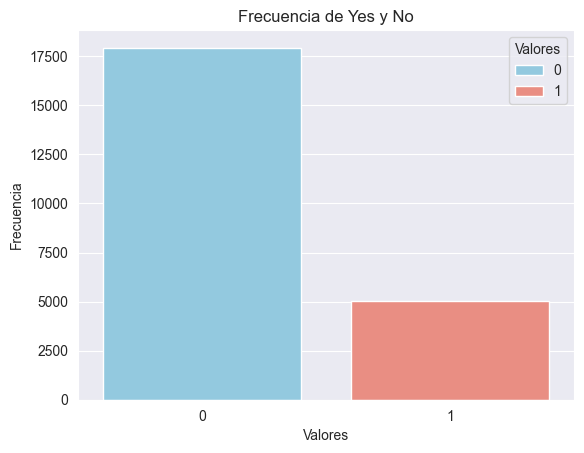

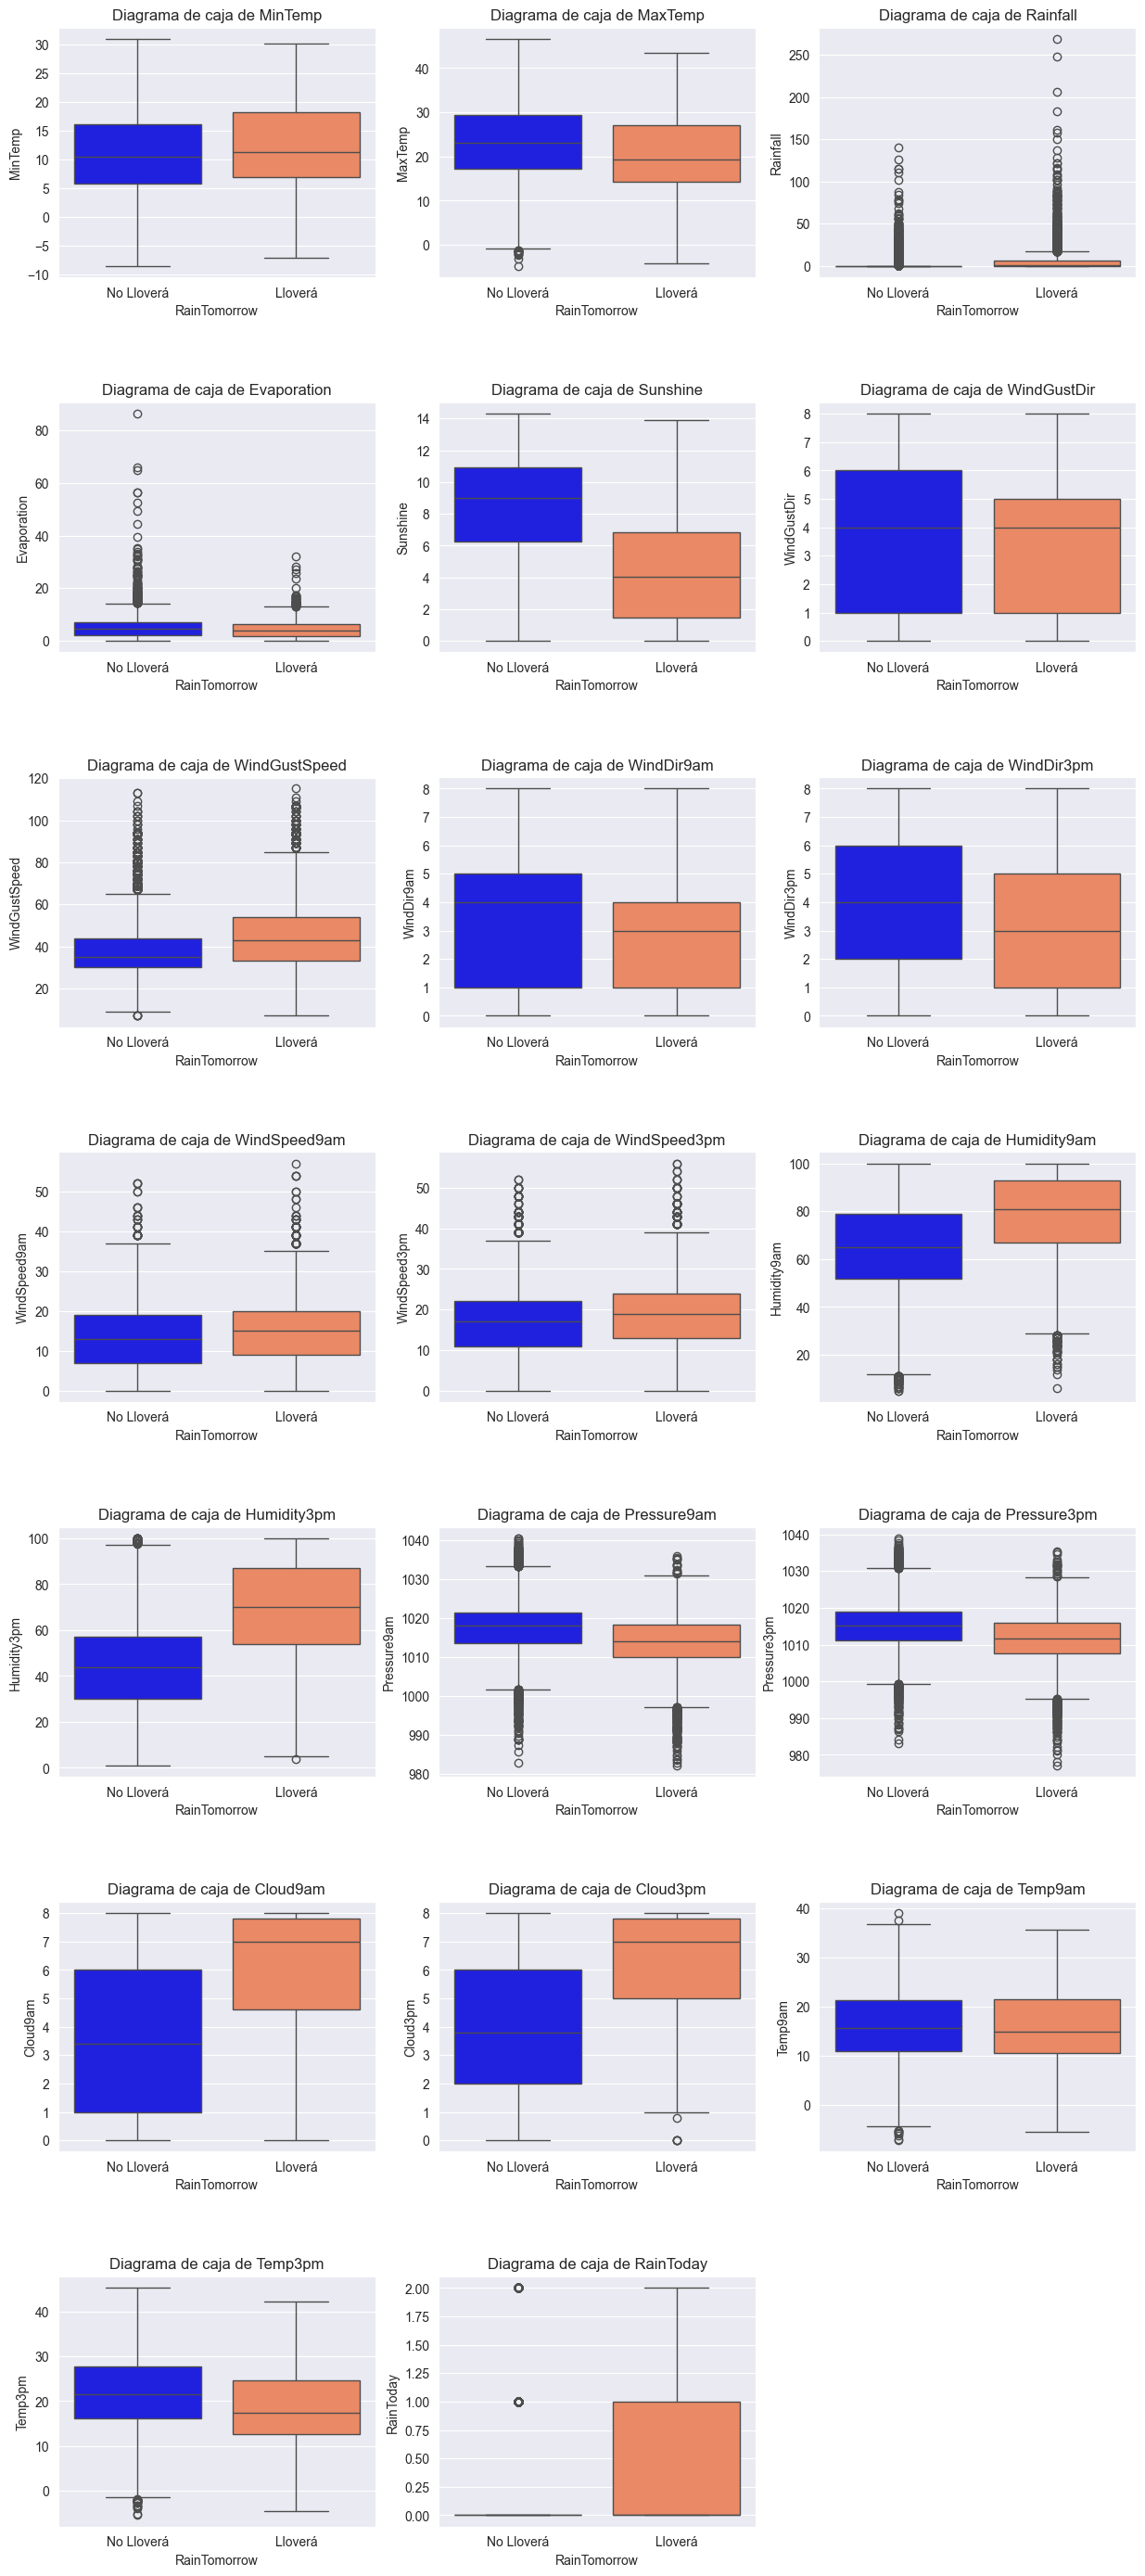

In [532]:
def boxplots(X,y, columns):
  data = pd.concat([pd.DataFrame(y, columns=['RainTomorrow']), pd.DataFrame(X, columns=columns)], axis=1)

  num_features = X.shape[1]
  num_rows = num_features // 3 +1

  fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
  fig.subplots_adjust(hspace=0.5)

  # Se recorre cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(data.columns[1:]):
      row = i // 3
      col = i % 3
      sns.boxplot(x='RainTomorrow', y=feature, hue='RainTomorrow', data=data, ax=axes[row, col], palette=['blue', 'coral'], legend=False)
      axes[row, col].set_title(f'Diagrama de caja de {feature}')
      axes[row, col].set_xlabel('RainTomorrow')
      axes[row, col].set_ylabel(feature)
      axes[row, col].set_xticks([0, 1])
      axes[row, col].set_xticklabels(['No Lloverá', 'Lloverá'])

  # Eliminar subplots vacíos si es necesario
  if num_features % 3 != 0:
      for i in range(num_features % 3, 3):
          fig.delaxes(axes[num_rows - 1, i])

  plt.show()


# Calcular la frecuencia de cada valor
dataframe = pd.DataFrame(y_train)
value_counts = dataframe[0].value_counts().reset_index()
value_counts.columns = ['Valores', 'Frecuencia']

# Crear el gráfico de barras
sns.barplot(x='Valores', y='Frecuencia', hue='Valores', data=value_counts, palette=['skyblue', 'salmon'])
plt.title('Frecuencia de Yes y No')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


boxplots(x_train_imputer_v2, y_train, x_train_imputer_v2.columns)

### Escalado de Datos

In [543]:
scaler=StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputer_v2)
x_test_scaled = scaler.transform(x_test_imputer_v2)

In [534]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(x_train_scaled, y_train)
y_pred = logistic_model.predict(x_test_scaled)

accuracy_logreg = accuracy_score(y_test, y_pred)
confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
classification_report_logreg = classification_report(y_test, y_pred)

print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg}')
print("\nMatriz de confusión:")
print(confusion_matrix_logreg)
print("\nReporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg:
Precisión: 0.8461404425858163

Matriz de confusión:
[[4228  275]
 [ 608  628]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      4503
           1       0.70      0.51      0.59      1236

    accuracy                           0.85      5739
   macro avg       0.78      0.72      0.75      5739
weighted avg       0.84      0.85      0.84      5739



c:\Users\rocio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [535]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logistic_model.predict_proba(x_test_scaled)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

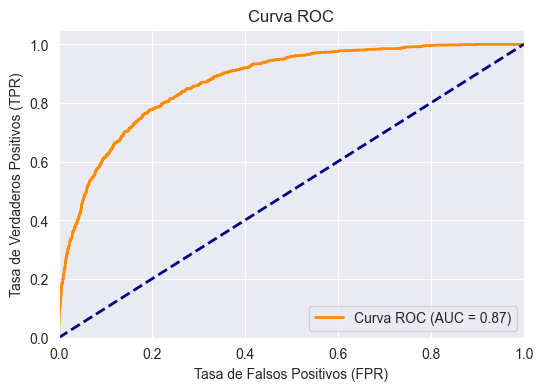

In [536]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [537]:
logistic_model2 = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model2.fit(x_train_scaled, y_train)
y_pred = logistic_model2.predict(x_test_scaled)

accuracy_logreg = accuracy_score(y_test, y_pred)
confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
classification_report_logreg = classification_report(y_test, y_pred)

print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg}')
print("\nMatriz de confusión:")
print(confusion_matrix_logreg)
print("\nReporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg:
Precisión: 0.7994424115699599

Matriz de confusión:
[[3632  871]
 [ 280  956]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4503
           1       0.52      0.77      0.62      1236

    accuracy                           0.80      5739
   macro avg       0.73      0.79      0.74      5739
weighted avg       0.84      0.80      0.81      5739



c:\Users\rocio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [538]:
# Obtengo las probabilidades de predicción del modelo
y_probs2 = logistic_model2.predict_proba(x_test_scaled)[:, 1]

# Calculo la ROC y el AUC
fpr2, tpr2, thresholds = roc_curve(y_test, y_probs2)
roc_auc2 = auc(fpr2, tpr2)

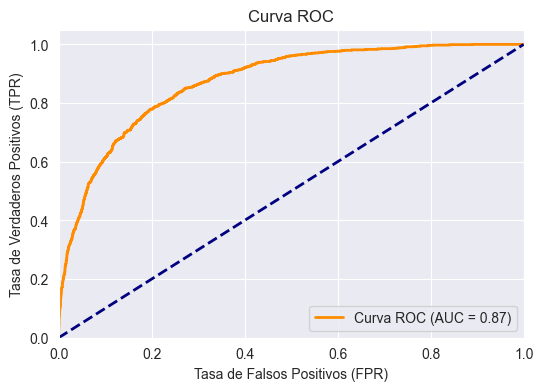

In [539]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Modelo base

In [544]:
dummy_clf = DummyClassifier(strategy="stratified",random_state=42) # aprender qué hace
"""“stratified”: the predict_proba method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities.
 The predict method returns 
the class label which got probability one in the one-hot vector of predict_proba. Each sampled row of both methods is therefore independent and identically distributed."""
dummy_clf.fit(x_train_scaled, y_train)
dummy_pred = dummy_clf.predict(x_test_scaled)

accuracy_logreg = accuracy_score(y_test, dummy_pred)
confusion_matrix_logreg = confusion_matrix(y_test, dummy_pred)
classification_report_logreg = classification_report(y_test, dummy_pred)

print("Métricas para DummyClassifier:")
print(f'Precisión: {accuracy_logreg}')
print("\nMatriz de confusión:")
print(confusion_matrix_logreg)
print("\nReporte de clasificación:")
print(classification_report_logreg)

Métricas para DummyClassifier:
Precisión: 0.6630074925945286

Matriz de confusión:
[[3536  967]
 [ 967  269]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4503
           1       0.22      0.22      0.22      1236

    accuracy                           0.66      5739
   macro avg       0.50      0.50      0.50      5739
weighted avg       0.66      0.66      0.66      5739



In [541]:
# Obtengo las probabilidades de predicción del modelo
y_probs_dummy = dummy_clf.predict_proba(x_test_scaled)[:, 1]

# Calculo la ROC y el AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, y_probs_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

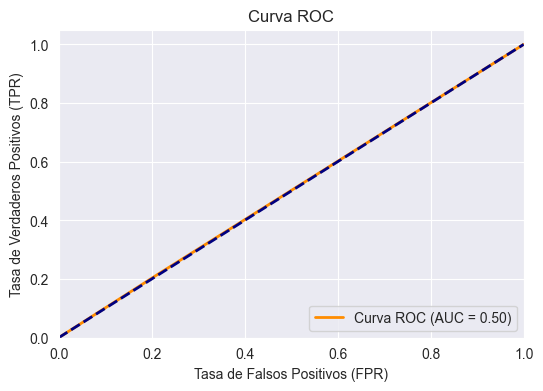

In [542]:
# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_dummy, tpr_dummy, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_dummy)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

El área debajo de la curva (AUC) dio 0.5. Esto ocurre cuando el modelo no tiene capacidad discriminativa, lo cual es correcto, ya que nuestro DummyClassifier está clasificando de manera totalmente aleatoria. 